## LSTM (Long Short-Term Memory) ile Hisse Senedi Fiyatı Tahminlemesi

1) İş Problemi (Business Problem)

2) Veriyi Anlamak (Data Understanding)

3) Veriyi Hazırlamak (Data Preparation)

4) Modelleme (Modeling)

5) Değerlendirme (Evaluation)

### 1) İş Problemi (Business Problem)

- **Date:** İlgili işlem gününün tarihini temsil etmektedir.
- **Open:** İlgili işlem gününe ait açılış fiyatını temsil etmektedir.
- **High:** İlgili işlem gününe ait en yüksek fiyatı temsil etmektedir.
- **Low:** İlgili işlem gününe ait en düşük fiyatı temsil etmektedir.
- **Close:** İlgili işlem gününe ait kapanış fiyatını temsil etmektedir.
- **Adj Close:** İlgili işlem gününe ait hisse senedinin düzeltilmiş kapanış fiyatını temsil etmektedir.
- **Volume:** İlgili işlem gününe ait işlem hacim bilgisini temsil etmektedir.

- **Veri Seti:** [Kaggle](https://www.kaggle.com/timoboz/tesla-stock-data-from-2010-to-2020)

### 2) Veriyi Anlamak (Data Understanding)

In [1]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmak için kullanılacak olan kütüphaneler
import warnings
warnings.filterwarnings("ignore")

# Tensorflow warning engellemek için kullanılacak olan kütüphaneler
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
df = pd.read_csv("TSLA.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(df)

##################### Shape #####################
(2416, 7)
##################### Types #####################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
##################### Head #####################
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
##################### Tail #####################
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575

TypeError: unsupported operand type(s) for -: 'str' and 'str'

### 3) Veriyi Hazırlamak (Data Preparation)

In [6]:
df["Date"] = pd.to_datetime(df["Date"])

In [7]:
tesla_df = df[["Date", "Close"]]

In [8]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [9]:
print("Minimum Tarih:", tesla_df["Date"].min())
print("Maximum Tarih:", tesla_df["Date"].max())

Minimum Tarih: 2010-06-29 00:00:00
Maximum Tarih: 2020-02-03 00:00:00


In [10]:
tesla_df.index = df["Date"]
tesla_df.drop(columns="Date", axis=1, inplace=True)

In [11]:
tesla_df.head()

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


In [12]:
result_df = tesla_df.copy()

In [13]:
result_df.head()

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


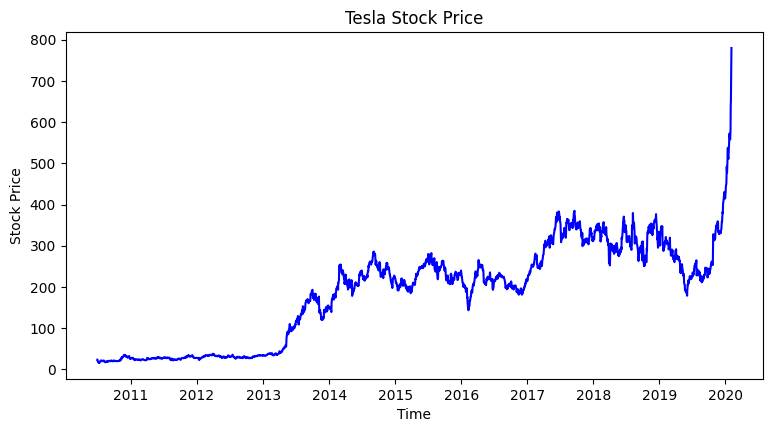

In [14]:
plt.figure(figsize=(9,4.5))
plt.plot(tesla_df["Close"], color="blue");
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price")
plt.xlabel("Time")
plt.show()

In [15]:
# Numpy array'ine çevirme işlemi

tesla_df = tesla_df.values

In [16]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [17]:
tesla_df = tesla_df.astype("float32")

In [18]:
# Train - Test Ayrımının Yapılması
# Zaman serilerinde zamansallık bozulacağı için random bir şekilde train_test_split yapamıyoruz bu yüzden aşağıdaki gibi bir fonksiyon tanımladık.

def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [19]:
train, test, position = split_data(tesla_df, 0.2)

In [20]:
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [21]:
# Data leakage olmaması için train ve test setlerini ayrı ayrı standartlaştırıyoruz.

scaler_train = MinMaxScaler(feature_range = (0, 1))
train = scaler_train.fit_transform(train)

scaler_test = MinMaxScaler(feature_range = (0, 1))
test = scaler_test.fit_transform(test)

In [22]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [23]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [24]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    
    return np.array(X), np.array(Y)

In [25]:
lookback = 20

In [26]:
# Train Veri Seti
X_train, y_train = create_features(train, lookback)

# Test Veri Seti
X_test, y_test = create_features(test, lookback)

In [27]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [28]:
# Sinir ağına uygun şekilde boyut ekleme işlemi

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


### 4) Modelleme (Modeling)

In [29]:
model = Sequential()

model.add(LSTM(units=50,
              activation="relu",
              input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması

model.compile(loss="mean_squared_error", optimizer="adam")

In [32]:
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"),
            ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]

In [33]:
history = model.fit(x=X_train,
                   y=y_train,
                   epochs=100,
                   batch_size=20,
                   validation_data=(X_test, y_test),
                   callbacks=callbacks,
                   shuffle=False)

Epoch 1/100
 1/96 [..............................] - ETA: 25s - loss: 1.0112e-04
Epoch 1: val_loss improved from inf to 0.00415, saving model to mymodel.h5
96/96 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.0041
Epoch 2/100
 1/96 [..............................] - ETA: 0s - loss: 0.0058
Epoch 2: val_loss improved from 0.00415 to 0.00367, saving model to mymodel.h5
96/96 [==============================] - 0s 626us/step - loss: 0.0063 - val_loss: 0.0037
Epoch 3/100
 1/96 [..............................] - ETA: 0s - loss: 0.0022
Epoch 3: val_loss improved from 0.00367 to 0.00319, saving model to mymodel.h5
96/96 [==============================] - 0s 626us/step - loss: 0.0050 - val_loss: 0.0032
Epoch 4/100
 1/96 [..............................] - ETA: 0s - loss: 0.0018
Epoch 4: val_loss did not improve from 0.00319
96/96 [==============================] - 0s 559us/step - loss: 0.0045 - val_loss: 0.0034
Epoch 5/100
 1/96 [..............................] - ETA:

### 5) Değerlendirme (Evaluation)

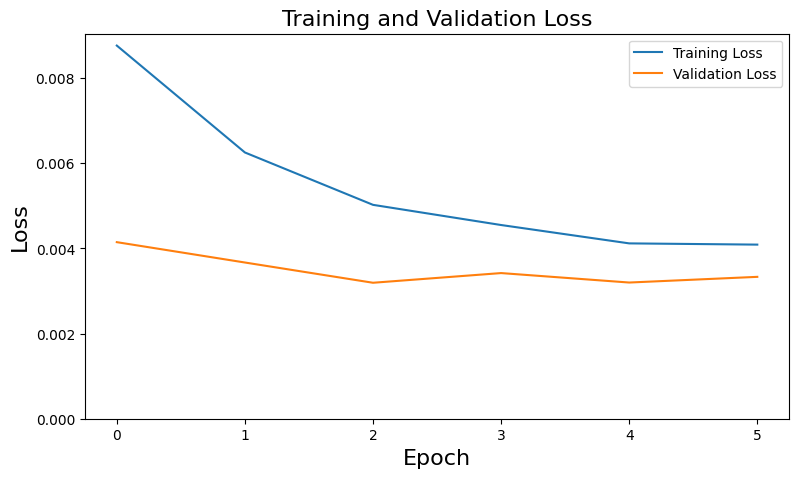

In [34]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()

In [35]:
loss = model.evaluate(X_test, y_test, batch_size=1)
print("\nTest Loss: %.1f%%" % (100.0 * loss))

463/463 [==============================] - 0s 260us/step - loss: 0.0033

Test Loss: 0.3%


In [36]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 390us/step


In [37]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [38]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [39]:
# Train Veri Setine Ait RMSE Değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

# Test Veri Setine Ait RMSE Değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 21.634925842285156
Test RMSE: 34.69366455078125


In [40]:
train_prediction_df = result_df[lookback:position]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,30.424463
2010-07-29,20.350000,30.423492
2010-07-30,19.940001,30.371014
2010-08-02,20.920000,30.282846
2010-08-03,21.950001,30.295544


In [41]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,299.018250
2018-04-04,286.940002,296.187866
2018-04-05,305.720001,291.961487
2018-04-06,299.299988,291.360260
2018-04-09,289.660004,290.979126


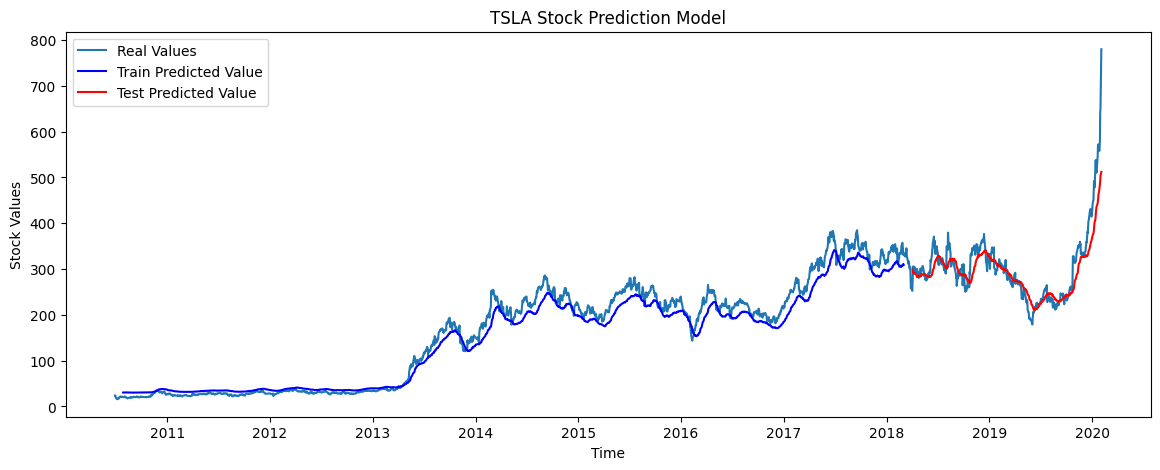

In [43]:
# Train ve Test Tahminlerini Ayrı Ayrı Görselleştirme İşlemi
plt.figure(figsize=(14,5))
plt.plot(result_df, label = "Real Values")
plt.plot(train_prediction_df["Predicted"], color = "blue", label = "Train Predicted Value")
plt.plot(test_prediction_df["Predicted"], color = "red", label = "Test Predicted Value")
plt.title("TSLA Stock Prediction Model")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show() 